## Setup

**Imports**

In [1]:
#%pip install -r requirements.txt

In [2]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import neurokit2 as nk

import IPython.display as ipd
from scipy.signal import medfilt
from numpy.fft import rfft, rfftfreq
from numpy.polynomial.polynomial import Polynomial
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt
from scipy.signal import argrelmax, periodogram
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf

**Utility functions**

In [3]:
try:
    from numpy.lib.stride_tricks import sliding_window_view  # New in version 1.20.0

    def get_trajectory_matrix(arr, window_shape, jump=1):
        return sliding_window_view(x=arr, window_shape=window_shape)[::jump]

except ImportError:

    def get_trajectory_matrix(arr, window_shape, jump=1):
        n_rows = ((arr.size - window_shape) // jump) + 1
        n = arr.strides[0]
        return np.lib.stride_tricks.as_strided(
            arr, shape=(n_rows, window_shape), strides=(jump * n, n)
        )
    
def fig_ax(figsize=(15, 4)):
    return plt.subplots(figsize=figsize)

def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1
) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[all_local_max.argsort()[::-1]][
        :n_largest
    ]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

def average_anti_diag(traj_matrix: np.ndarray) -> np.ndarray:
    """Average anti diagonal elements of a 2d array"""
    x1d = [
        np.mean(traj_matrix[::-1, :].diagonal(i))
        for i in range(-traj_matrix.shape[0] + 1, traj_matrix.shape[1])
    ]
    return np.array(x1d)

## Signal prediction

In this section, we do Basis Function Regression to forecast the synthetic signal. All our features are only computed from the temporal index t (Fourier : $\sin(\omega t)$, $\cos(\omega t)$ Polynôme : $t^2$, $t^3$ (ou Chebyshev)RBF/Gabor : $e^{-(t-c)^2}$)

Le signal réel (daily_taxi_count) n'est utilisé que comme cible ($y$) pour calculer l'erreur lors de l'entraînement, pas comme input ($X$) à ce stade.

## Data

In [4]:
"""X=pd.read_csv('nyc_taxi.csv')
X["timestamp"] = pd.to_datetime(X["timestamp"])
daily_taxi_count = X.resample("1D", on="timestamp").sum()
daily_taxi_count_np = daily_taxi_count.to_numpy().squeeze()
fig, ax = fig_ax()
ax.plot(daily_taxi_count, "*-")
_ = ax.set_ylim(0)"""

'X=pd.read_csv(\'nyc_taxi.csv\')\nX["timestamp"] = pd.to_datetime(X["timestamp"])\ndaily_taxi_count = X.resample("1D", on="timestamp").sum()\ndaily_taxi_count_np = daily_taxi_count.to_numpy().squeeze()\nfig, ax = fig_ax()\nax.plot(daily_taxi_count, "*-")\n_ = ax.set_ylim(0)'

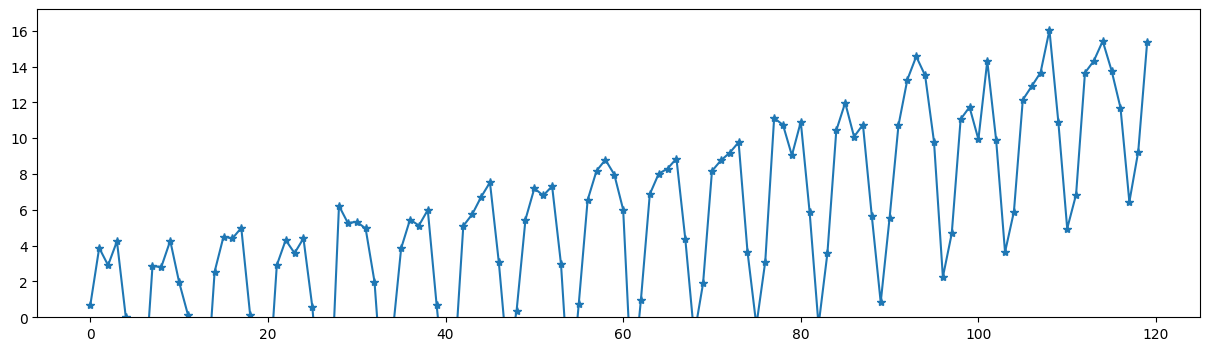

In [5]:
n_days = 120  # ~4 mois. Assez court pour être lisible point par point.
t = np.arange(n_days)

# TENDANCE: Quadratique (pour que ce ne soit pas trop simple)
trend = 0.05 * t + 0.0005 * (t ** 2)

# SAISONNALITÉ: Hebdomadaire (Période 7)
# On utilise Période=7 car votre dictionnaire contient sûrement des features pour 7 jours.
seasonality = 5 * np.sin(2 * np.pi * t / 7) + 2 * np.cos(4 * np.pi * t / 7)

# BRUIT: Léger
noise = np.random.normal(0, 1.0, size=n_days)

# Signal Total
daily_taxi_count_np = trend + seasonality + noise

fig, ax = fig_ax()
ax.plot(daily_taxi_count_np, "*-")
_ = ax.set_ylim(0)

In [6]:
def plot_ground_truth(y_true, time_array, feature_names, true_indices, true_weights):
    """
    Affiche le signal synthétique pur et les coefficients 'générateurs' dans la base.
    
    Args:
        y_true: Le signal synthétique complet (sans bruit idéalement, ou avec).
        time_array: L'axe temporel.
        feature_names: La liste des noms de colonnes de votre dictionnaire (X_mega.columns).
        true_indices: Liste des indices des features utilisées pour créer le signal.
        true_weights: Liste des poids associés à ces indices.
    """
    
    # Configuration de la figure
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1.5, 1.5]})
    plt.subplots_adjust(hspace=0.5)

    # === GRAPHIQUE 1 : LE SIGNAL DE RÉFÉRENCE ===
    ax1 = axes[0]
    ax1.plot(time_array, y_true, color='black', linewidth=1.5, label="Signal Synthétique (Ground Truth)")
    ax1.set_title("Signal de Référence (Généré par des features connues)")
    ax1.set_ylabel("Amplitude")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # === GRAPHIQUE 2 : LES VRAIS COEFFICIENTS (RECETTE) ===
    ax2 = axes[1]
    
    # Conversion en numpy array pour faciliter l'indexation
    indices = np.array(true_indices)
    weights = np.array(true_weights)
    
    # On récupère les noms correspondants dans le dictionnaire
    # Attention : il faut que feature_names soit un array ou une liste accessible par index
    names = np.array(feature_names)[indices]
    
    # --- Tri pour l'affichage (Plus gros poids à gauche) ---
    sorted_idx = np.argsort(np.abs(weights))[::-1]
    sorted_weights = weights[sorted_idx]
    sorted_names = names[sorted_idx]
    
    # Couleurs : Bleu (+) / Rouge (-)
    colors = ['tab:blue' if w > 0 else 'tab:red' for w in sorted_weights]
    
    # Bar Chart
    x_pos = np.arange(len(sorted_weights))
    bars = ax2.bar(x_pos, sorted_weights, color=colors, alpha=0.8)
    
    # Labels
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(sorted_names, rotation=45, ha='right', fontsize=11, fontweight='bold')
    
    # Valeurs sur les barres
    for bar, val in zip(bars, sorted_weights):
        y_val = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, y_val + (0.05 if y_val>0 else -0.15), 
                 f"{val:.2f}", ha='center', va='bottom' if y_val>0 else 'top', fontsize=9)

    ax2.set_title(f"Les Vrais Coefficients (Ingrédients du Signal)")
    ax2.set_ylabel("Poids réel")
    ax2.axhline(0, color='black', linewidth=0.8)
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Ajuster les limites Y pour que le texte ne soit pas coupé
    y_max = np.max(np.abs(sorted_weights)) * 1.2
    ax2.set_ylim(-y_max, y_max)

    plt.show()

# Signal Prediction

The objective is to predict the daily taxi for the next two weeks (30 days).
First, we prepare the training and testing data.

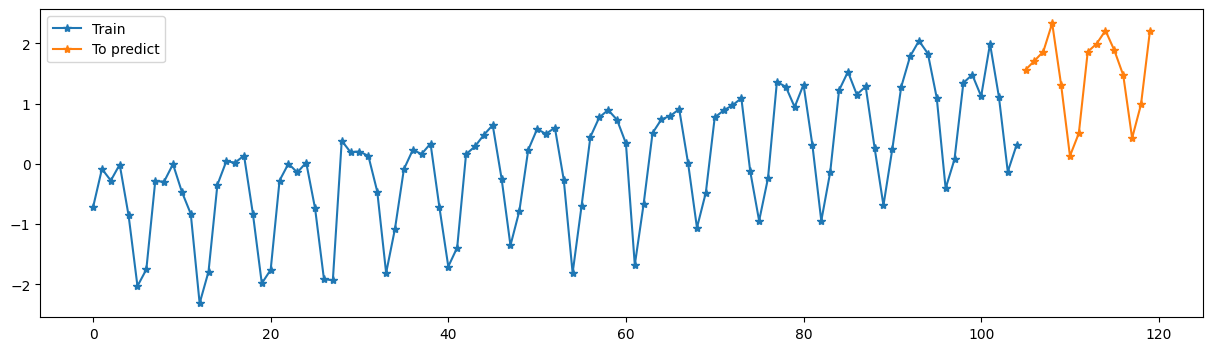

In [7]:
n_samples_pred = 15  # predict the next 30 samples

# train/test split
signal_train, signal_pred = np.split(
    daily_taxi_count_np.astype(float), [-n_samples_pred]
)
n_samples = n_samples_train = signal_train.size

# scaling
scaler = StandardScaler().fit(signal_train.reshape(-1, 1))
signal_train = scaler.transform(signal_train.reshape(-1, 1)).flatten()
signal_pred = scaler.transform(signal_pred.reshape(-1, 1)).flatten()

# keep the indexes of train and test (for plotting mostly)
time_array_train, time_array_pred = np.split(
    np.arange(daily_taxi_count_np.size), [-n_samples_pred]
)
time_array = time_array_train
"""calendar_time_array = daily_taxi_count.iloc[time_array].index.to_numpy()"""
calendar_time_array = daily_taxi_count_np[time_array]


signal_full = np.concatenate([signal_train, signal_pred])

# plot
fig, ax = fig_ax()
ax.plot(time_array_train, signal_train, "-*", label="Train")
ax.plot(time_array_pred, signal_pred, "-*", label="To predict")
_ = plt.legend()

# Dictionnary extraction

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

class FourierAtomDictionary:
    """
    Generates a dictionary composed ONLY of Sine and Cosine waves.
    No lags, no rolling stats.
    """
    def __init__(self, period_guesses=[7, 365.25], n_harmonics=10):
        """
        period_guesses: The cycles you suspect exist (e.g. 7 days, 365 days).
        n_harmonics: How many 'overtones' to generate for each cycle.
                     Higher = captures sharper spikes. Lower = smoother waves.
        """
        self.periods = period_guesses
        self.n_harmonics = n_harmonics

    def fit_transform(self, signal):
        n = len(signal)
        t = np.arange(n)
        features = pd.DataFrame()
        
        # 1. Generate Fourier Atoms
        for period in self.periods:
            # Fundamental Frequency (e.g., 1/7th of a day)
            base_w = 2 * np.pi / period
            
            for k in range(1, self.n_harmonics + 1):
                # Harmonics: k * base_freq
                w = base_w * k
                features[f'sin_{period}_{k}'] = np.sin(w * t)
                features[f'cos_{period}_{k}'] = np.cos(w * t)
        
        # 2. Add a simple Linear Trend (Optional but recommended for Fourier)
        # Pure Fourier assumes the signal average never changes. 
        # Adding 't' allows it to slope up/down.
        features['trend_linear'] = t
        
        # No rows dropped because Fourier is calculated for all 't'
        target = pd.Series(signal)
        
        return features, target
    
import numpy as np
import pandas as pd
from scipy.special import eval_chebyt

class PolynomialAtomDictionary:
    """
    CORRECTED: Allows consistent time normalization across Train and Test.
    """
    def __init__(self, degree=5, t_min=0, t_max=1000):
        self.degree = degree
        # On définit les bornes globales attendues du signal complet
        self.t_min = t_min
        self.t_max = t_max

    def fit_transform(self, signal, time_index=None):
        """
        time_index: The actual time steps corresponding to the signal.
                    If None, assumes np.arange(len(signal)) but WARNS user.
        """
        n = len(signal)
        
        # Si on ne fournit pas le vrai index temporel, on suppose qu'il commence à 0
        # (Dangereux pour le test set !)
        if time_index is None:
            time_index = np.arange(n) 
            
        # Normalisation cohérente : map [t_min, t_max] -> [-1, 1]
        # Formule : 2 * (t - min) / (max - min) - 1
        t_norm = 2 * (time_index - self.t_min) / (self.t_max - self.t_min) - 1
        
        features = pd.DataFrame(index=range(n))
        
        for d in range(1, self.degree + 1):
            poly = eval_chebyt(d, t_norm)
            features[f'poly_deg_{d}'] = poly
            
        target = pd.Series(signal)
        return features, target

from scipy.stats import norm

class RBFAtomDictionary:
    """
    Generates a dictionary of Gaussian (Radial Basis Function) atoms.
    Captures LOCALIZED events or bumps at specific times.
    """
    def __init__(self, n_centers=20, widths=[5, 20]):
        """
        n_centers: How many 'bumps' to spread across the timeline.
        widths: The spread (sigma) of the bumps. Small=Spike, Large=Hill.
        """
        self.n_centers = n_centers
        self.widths = widths

    def fit_transform(self, signal):
        n = len(signal)
        t = np.arange(n)
        features = pd.DataFrame()
        
        # Place centers evenly across the time range
        centers = np.linspace(0, n, self.n_centers)
        
        for width in self.widths:
            for i, center in enumerate(centers):
                # Gaussian Bell Curve: exp(-0.5 * ((t - center) / width)^2)
                atom = np.exp(-0.5 * ((t - center) / width)**2)
                
                # Only add if it has significant magnitude (optimization)
                if np.max(atom) > 1e-3:
                    features[f'gauss_w{width}_loc{int(center)}'] = atom
                    
        target = pd.Series(signal)
        return features, target
    
class GaborAtomDictionary:
    """
    Generates Gabor atoms: Gaussian-windowed sinusoids.
    Captures transient oscillations (e.g., a burst of weekly rhythm).
    Formula: exp(-0.5 * ((t-mu)/sigma)^2) * cos(w * t)
    """
    def __init__(self, n_centers=20, widths=[10, 30], frequencies=[7, 30]):
        """
        frequencies: The periodicities to capture (e.g., 7 days, 30 days).
        widths: How long the burst lasts (sigma).
        """
        self.n_centers = n_centers
        self.widths = widths
        self.frequencies = frequencies

    def fit_transform(self, signal):
        n = len(signal)
        t = np.arange(n)
        features = pd.DataFrame()
        
        # Centers spread across time
        centers = np.linspace(0, n, self.n_centers)
        
        for freq in self.frequencies:
            w = 2 * np.pi / freq
            for width in self.widths:
                for center in centers:
                    # The Envelope (Gaussian)
                    envelope = np.exp(-0.5 * ((t - center) / width)**2)
                    
                    # Optimization: Skip if envelope is effectively zero everywhere
                    if np.max(envelope) < 1e-3:
                        continue
                        
                    # Gabor Atom (Cosine and Sine phases)
                    # We add both to capture phase shifts
                    features[f'gabor_cos_f{freq}_w{width}_t{int(center)}'] = envelope * np.cos(w * t)
                    features[f'gabor_sin_f{freq}_w{width}_t{int(center)}'] = envelope * np.sin(w * t)
                    
        target = pd.Series(signal)
        return features, target
    
import pywt
from scipy.interpolate import interp1d

class WaveletBasisDictionary:
    """
    Generates shifted versions of a specific Wavelet function (e.g., db4).
    Captures sharp transitions, spikes, and jagged features.
    """
    def __init__(self, wavelet_name='db4', scales=[5, 10, 20], stride=10):
        """
        scales: The 'width' or dilation of the wavelet.
        stride: How many steps to shift the wavelet across time.
        """
        self.wavelet_name = wavelet_name
        self.scales = scales
        self.stride = stride

    def fit_transform(self, signal):
        n = len(signal)
        t_grid = np.arange(n)
        features = pd.DataFrame()
        
        # 1. Get the Mother Wavelet Shape (phi, psi, x)
        wavelet = pywt.Wavelet(self.wavelet_name)
        # wavefun returns [phi, psi, x_grid] for orthogonal wavelets
        # We only care about psi (the wavelet function), not phi (scaling)
        try:
            _, psi, x_vals = wavelet.wavefun(level=5)
        except:
            # Fallback for biorthogonal etc if needed
            psi, _, _, _, x_vals = wavelet.wavefun(level=5)

        # Create an interpolator to resize the wavelet to our desired scales
        # We map the wavelet's domain [min, max] to [-1, 1] for easier scaling
        t_norm = (x_vals - x_vals.min()) / (x_vals.max() - x_vals.min()) * 2 - 1
        interpolator = interp1d(t_norm, psi, kind='linear', fill_value=0.0, bounds_error=False)

        # 2. Generate Atoms (Shift and Scale)
        for scale in self.scales:
            # Define the window size in time steps based on scale
            # (Arbitrary mapping: let's say scale=10 means width approx 20 days)
            width_in_days = scale * 2
            
            # Local grid for the wavelet (e.g. from -1 to 1)
            t_local = np.linspace(-1, 1, width_in_days)
            wavelet_shape = interpolator(t_local)
            
            # Slide across the signal
            for loc in range(0, n, self.stride):
                # Create zero vector
                atom = np.zeros(n)
                
                # Determine start/end indices
                start = loc - width_in_days // 2
                end = start + width_in_days
                
                # Handle boundaries (clip to 0..n)
                sig_start = max(0, start)
                sig_end = min(n, end)
                
                # Slice the wavelet shape to fit
                wav_start = sig_start - start
                wav_end = wav_start + (sig_end - sig_start)
                
                atom[sig_start:sig_end] = wavelet_shape[wav_start:wav_end]
                
                # Add to dictionary if it has energy
                if np.sum(atom**2) > 1e-4:
                    features[f'wav_{self.wavelet_name}_s{scale}_t{loc}'] = atom
                    
        target = pd.Series(signal)
        return features, target

In [9]:
# --- 2. Generate Mega Dictionary on FULL Signal ---
print("Generating dictionaries on full timeline...")

# Fourier (Seasonality)
X_fourier, _ = FourierAtomDictionary(period_guesses=[7, 365], n_harmonics=20).fit_transform(signal_full)

# Polynomial (Trend)
X_poly, _    = PolynomialAtomDictionary(degree=5).fit_transform(signal_full)

# RBF (Local Bumps)
X_rbf, _     = RBFAtomDictionary(n_centers=30, widths=[10]).fit_transform(signal_full)

# Gabor (Transient Periodicities)
X_gabor, _   = GaborAtomDictionary(n_centers=20, widths=[10], frequencies=[7]).fit_transform(signal_full)

# Wavelets (Spikes/Edges)
X_wave, _    = WaveletBasisDictionary(wavelet_name='db4', scales=[5, 15], stride=20).fit_transform(signal_full)

# Concatenate all to make the "Mega Matrix"
X_mega_full = pd.concat([X_fourier, X_poly, X_rbf, X_gabor, X_wave], axis=1)
print(f"Mega Dictionary Created: {X_mega_full.shape[1]} atoms.")

# --- 3. Split into Train and Test ---
# We split based on the number of prediction samples
X_train_mega = X_mega_full.iloc[:-n_samples_pred].values  # Everything except last 14
X_test_mega  = X_mega_full.iloc[-n_samples_pred:].values  # Last 14 only

y_train = signal_train
y_test  = signal_pred

Generating dictionaries on full timeline...
Mega Dictionary Created: 168 atoms.


In [10]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Le rôle de l'Estimateur (Linear Regression) : Son job est de mesurer la quantité d'information capturée par ces features, sans rien changer.

Si tu utilises un LASSO ou un Ridge fort derrière ton sélecteur, tu ajoutes un "filtre" supplémentaire. Si le score est bon, on ne saura jamais si c'est grâce à mRMR ou grâce au nettoyage fait par LASSO ensuite.

Avec une Linear Regression simple, tu dis : "Voici les features brutes sélectionnées par mRMR. Débrouille-toi avec ça." Si le RMSE explose, c'est la faute de mRMR (qui a laissé passer de la colinéarité), pas celle du modèle.

In [11]:
def fit_features(X_train, y_train, X_test, y_test, method_name="Method", time_train=None, time_test=None):
    """
    Fits a Linear regressor on the training set and forecasts on the test set.
    
    Args:
        X_train (np.array): Features for the training period.
        y_train (np.array): Target signal for the training period.
        X_test (np.array): Features for the prediction period (future).
        y_test (np.array): Ground truth for the prediction period (for evaluation).
        method_name (str): Label for the plot.
        time_train (np.array): Time indexes for training (for plotting).
        time_test (np.array): Time indexes for testing (for plotting).
        
    Returns:
        rmse (float): The root mean squared error on the test set.
        y_pred (np.array): The predicted values.
    """
    
    # 1. TRAIN 
    # Strictly on the training signal
    regressor = LinearRegression(fit_intercept=True)
    regressor.fit(X_train, y_train)
    
    # 2. PREDICT
    # Predict the test set (the next 14 samples)
    y_pred = regressor.predict(X_test)
    
    # 3. EVALUATE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"[{method_name}] Test RMSE: {rmse:.4f}")
    
    # 4. PLOT
    # If time arrays aren't provided, create dummy indices
    if time_train is None: time_train = np.arange(len(y_train))
    if time_test is None: time_test = np.arange(len(y_train), len(y_train) + len(y_test))

    plt.figure(figsize=(12, 5))
    
    # Plot only the last 100 days of training for better visibility
    plot_window = 100 
    start_plot_idx = max(0, len(time_train) - plot_window)

    plt.plot(time_train[start_plot_idx:], y_train[start_plot_idx:], 
             "-", color="tab:blue", alpha=0.6, label="Train (History)")
    
    plt.plot(time_test, y_test, 
             "-*", color="tab:blue", label="Actual Test (Hidden)")
    
    plt.plot(time_test, y_pred, 
             "--*", color="tab:orange", label=f"Forecast ({method_name})")
    
    plt.title(f"Forecast: {method_name} (RMSE: {rmse:.3f})")
    plt.xlabel("Time Index")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return rmse

In [12]:
def evaluate_and_plot_selection(X_train_full, y_train, X_test_full, y_test, 
                                selected_indices, feature_names, 
                                time_train, time_test, 
                                algo_name="My Selection"):
    """
    Entraîne une régression linéaire sur les features sélectionnées 
    et affiche la reconstruction + les coefficients (Histogramme Vertical).
    """
    
    # --- 1. Préparation des données (Slicing) ---
    X_train_sub = X_train_full[:, selected_indices]
    X_test_sub  = X_test_full[:, selected_indices]
    
    selected_feat_names = np.array(feature_names)[selected_indices]

    # --- 2. Modèle (Linear Regression simple) ---
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train_sub, y_train)
    
    y_train_pred = model.predict(X_train_sub)
    y_test_pred  = model.predict(X_test_sub)
    
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # --- 3. Visualisation ---
    # Augmentation de la hauteur pour laisser de la place aux labels inclinés en bas
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1.5]})
    plt.subplots_adjust(hspace=0.6) # Espace vertical augmenté entre les graphs

    # === GRAPHIQUE 1 : RECONSTRUCTION TEMPORELLE ===
    ax1 = axes[0]
    zoom_window = 100
    start_idx = max(0, len(time_train) - zoom_window)
    
    ax1.plot(time_train[start_idx:], y_train[start_idx:], 
             color='black', alpha=0.3, label="Signal Réel (Train)")
    ax1.plot(time_train[start_idx:], y_train_pred[start_idx:], 
             color='tab:green', linestyle='--', alpha=0.8, label="Reconstruction Modèle")
    
    ax1.plot(time_test, y_test, 
             color='black', marker='.', label="Signal Réel (Test)")
    ax1.plot(time_test, y_test_pred, 
             color='tab:red', marker='x', linestyle='--', linewidth=2, label="Prédiction")
    
    ax1.axvline(x=time_test[0], color='gray', linestyle=':', label="Split Train/Test")
    ax1.set_title(f"Reconstruction & Prédiction | Algo: {algo_name} | RMSE Test: {rmse_test:.3f}")
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # === GRAPHIQUE 2 : IMPORTANCE DES COEFFICIENTS (VERTICAL) ===
    ax2 = axes[1]
    
    coefs = model.coef_
    
    # Tri par amplitude absolue DESCENDANTE (les plus gros à gauche)
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    sorted_coefs = coefs[sorted_idx]
    sorted_names = selected_feat_names[sorted_idx]
    
    # Couleurs : Bleu si positif, Rouge si négatif
    colors = ['tab:blue' if c > 0 else 'tab:red' for c in sorted_coefs]
    
    x_pos = np.arange(len(sorted_coefs))
    
    # Bar chart Vertical
    ax2.bar(x_pos, sorted_coefs, color=colors)
    
    # Configuration axe X (Noms des features)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(sorted_names, rotation=60, ha='right', fontsize=10)
    
    # Configuration axe Y (Poids)
    ax2.set_ylabel("Valeur du Coefficient (Poids)")
    ax2.set_title(f"Coefficients de la Régression Linéaire ({len(coefs)} features)")
    
    # Grille horizontale pour lire les niveaux Y
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Ligne zéro pour référence
    ax2.axhline(0, color='black', linewidth=0.8)

    plt.show()
    
    return rmse_test

In [13]:
from sklearn.metrics import confusion_matrix

def evaluate_recovery(algo_name, selected_indices, true_indices, true_weights=None, feature_names=None):
    """
    Évalue rigoureusement la capacité d'un algo à retrouver les 'Vrais' indices.
    
    Args:
        algo_name (str): Nom de l'algo (ex: "Lasso", "MIM").
        selected_indices (list/array): Indices retournés par l'algo.
        true_indices (list): Les indices de la Ground Truth.
        true_weights (list, optional): Les poids réels (pour le score d'énergie).
        feature_names (list, optional): Pour afficher les noms des erreurs.
        
    Returns:
        pd.DataFrame: Une ligne de scores.
    """
    # Conversion en set pour opérations ensemblistes rapides
    sel_set = set(selected_indices)
    true_set = set(true_indices)
    
    # --- 1. Métriques Classiques (Classification) ---
    # Vrais Positifs (TP): Features correctes trouvées
    tp = len(sel_set.intersection(true_set))
    # Faux Positifs (FP): Features inutiles sélectionnées (Bruit)
    fp = len(sel_set - true_set)
    # Faux Négatifs (FN): Features réelles manquées
    fn = len(true_set - sel_set)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score  = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # --- 2. Métrique "Smart": Score d'Énergie (Weighted Recall) ---
    # Si on a les poids, on peut dire si on a raté un "gros" ou un "petit" morceau
    energy_score = None
    if true_weights is not None:
        # Dictionnaire {Index: Poids Absolu}
        weight_map = {idx: abs(w) for idx, w in zip(true_indices, true_weights)}
        
        total_energy = sum(weight_map.values())
        recovered_energy = sum([weight_map[idx] for idx in sel_set if idx in weight_map])
        
        energy_score = recovered_energy / total_energy if total_energy > 0 else 0.0

    # --- 3. Affichage Console (Feedback Immédiat) ---
    print(f"--- Évaluation : {algo_name} ---")
    print(f"✅ Trouvés ({tp}) : {[feature_names[i] for i in sel_set.intersection(true_set)] if feature_names is not None else tp}")
    print(f"❌ Manqués ({fn}) : {[feature_names[i] for i in true_set - sel_set] if feature_names is not None else fn}")
    print(f"⚠️ Intrus  ({fp}) : (Top 3) {[feature_names[i] for i in list(sel_set - true_set)[:3]] if feature_names is not None else fp}")
    if energy_score is not None:
        print(f"🔋 Énergie Retrouvée : {energy_score:.1%}")
    print("-" * 30)

    return {
        "Algorithm": algo_name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "Energy_Recovery": energy_score if energy_score else 0.0,
        "TP": tp, "FP": fp, "FN": fn
    }

## Reference signal

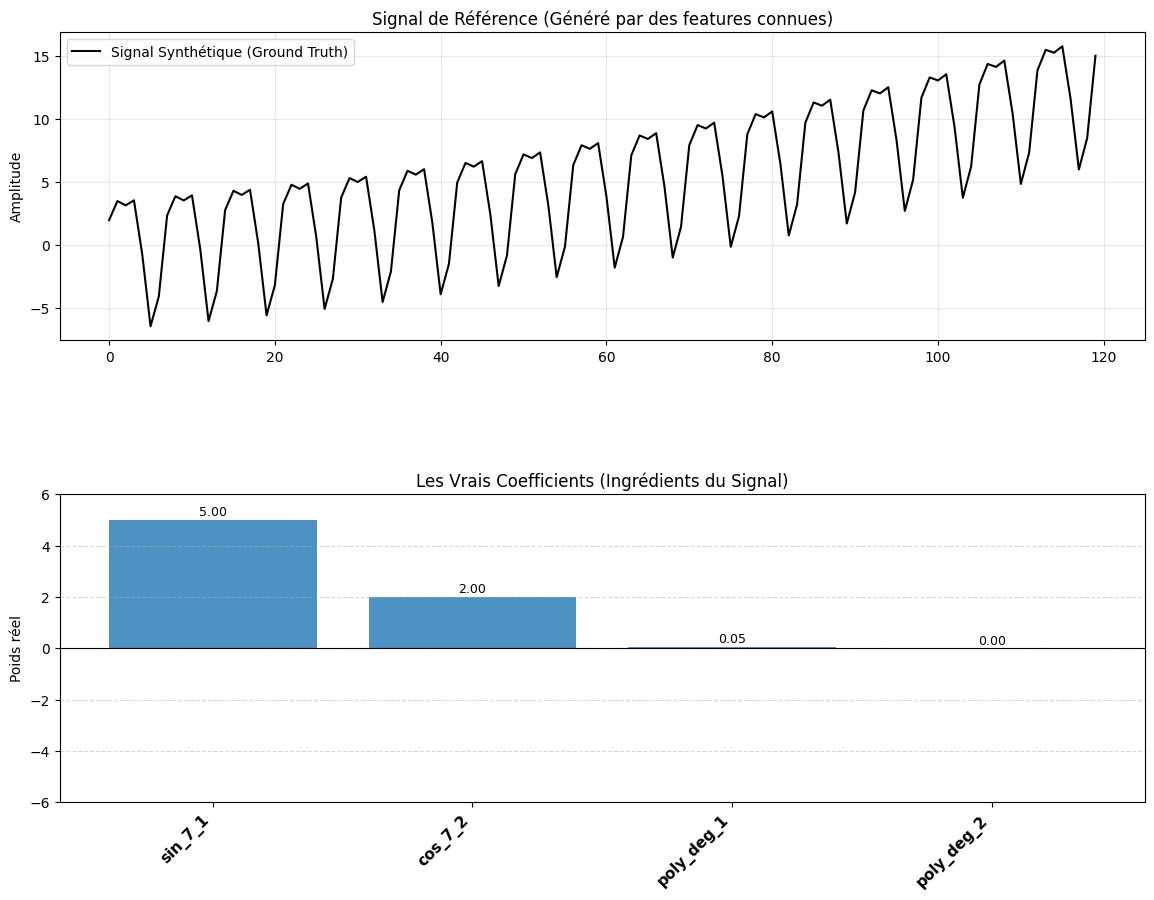

In [14]:
cols = list(X_mega_full.columns)

# -- Recherche des indices (C'est un peu "hacky" mais nécessaire pour la Ground Truth) --
idx_trend_1 = [i for i, c in enumerate(cols) if 'poly_deg_1' in c][0]
idx_trend_2 = [i for i, c in enumerate(cols) if 'poly_deg_2' in c][0]

# Pour Fourier, attention aux noms exacts générés par votre classe (ex: sin_7_1, cos_7_2)
# Adaptez les chaînes 'sin_7_1' selon le format exact de vos colonnes !
idx_sin_freq1 = [i for i, c in enumerate(cols) if 'sin_7_1' in c][0] # Fondamentale
idx_cos_freq2 = [i for i, c in enumerate(cols) if 'cos_7_2' in c][0] # Harmonique 2

# 2. DÉFINITION DE LA VÉRITÉ TERRAIN
# ==============================================================================
my_true_indices = [idx_trend_1, idx_trend_2, idx_sin_freq1, idx_cos_freq2]
my_true_weights = [0.05,        0.0005,      5.0,           2.0]

# 3. AFFICHAGE
# ==============================================================================
# On utilise le signal SANS bruit pour la référence visuelle propre (optionnel)
y_pure = trend + seasonality 

plot_ground_truth(
    y_true=y_pure, # ou daily_taxi_count_np si vous voulez voir le bruit
    time_array=t, 
    feature_names=X_mega_full.columns, 
    true_indices=my_true_indices, 
    true_weights=my_true_weights
)

# Feature selection

In [15]:
from skfeature.function.similarity_based import lap_score
from skfeature.function.information_theoretical_based import MIM
from skfeature.function.sparse_learning_based import ls_l21
from skfeature.function.statistical_based import f_score
from skfeature.utility import construct_W

In [16]:
k = 4

#### Laplacian score selection (unsupervised selection)

Running Laplacian Score (Unsupervised)...
Top Feature (Similarity - Laplacian): cos_365_2


C:\Users\PC\AppData\Local\Temp\ipykernel_17120\1957771404.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


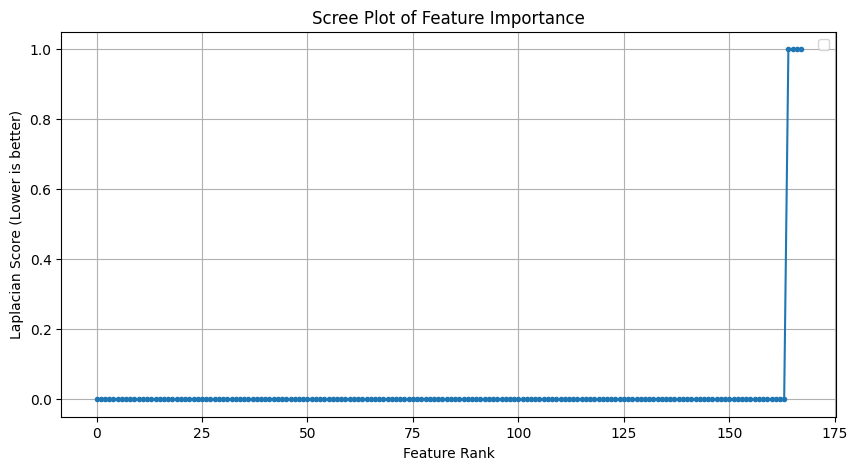

In [17]:
print("Running Laplacian Score (Unsupervised)...")
# Construct the affinity graph W
kwargs_W = {"metric": "euclidean", "neighbor_mode": "knn", "weight_mode": "heat_kernel", "k": 5, "t": 1.0}
W = construct_W.construct_W(X_train_mega, **kwargs_W)
# Calculate score
score_lap = lap_score.lap_score(X_train_mega, W=W)
idx_lap = np.argsort(score_lap) # Smallest score is best
print("Top Feature (Similarity - Laplacian):", X_mega_full.columns[idx_lap[0]])

# Plot Sorted Laplacian Scores
plt.figure(figsize=(10, 5))
# idx_lap sorts them, so we just grab the scores in that order
sorted_scores = score_lap[idx_lap]

plt.plot(sorted_scores, marker='.')
plt.xlabel("Feature Rank")
plt.ylabel("Laplacian Score (Lower is better)")
plt.title("Scree Plot of Feature Importance")
plt.legend()
plt.grid(True)
plt.show()

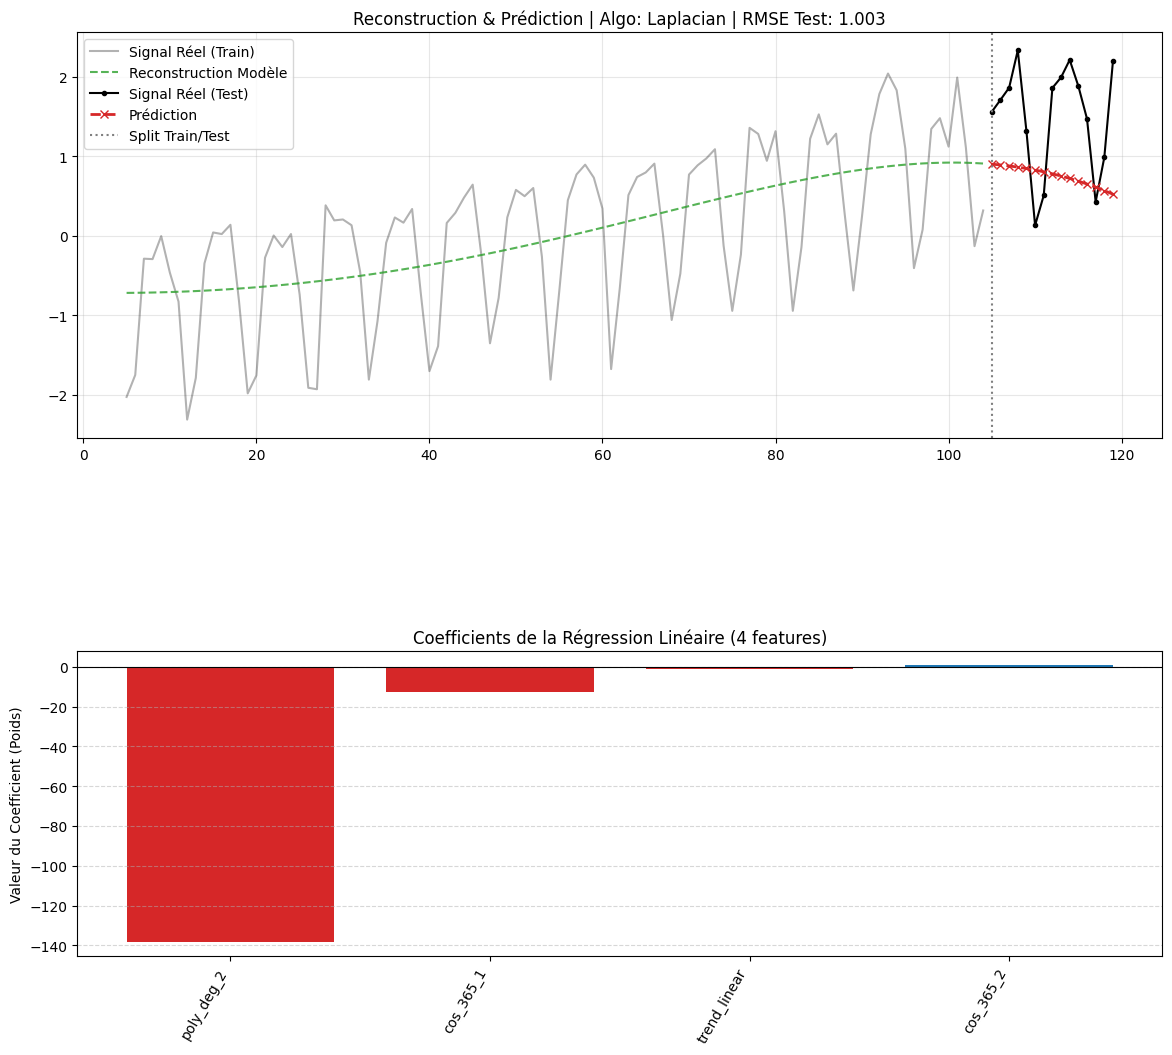

np.float64(1.0029200069678217)

In [18]:
top_k_indices = idx_lap[:k]
X_train_subset = X_train_mega[:, top_k_indices]
X_test_subset  = X_test_mega[:, top_k_indices]

evaluate_and_plot_selection(X_train_full=X_train_mega, 
    y_train=y_train, 
    X_test_full=X_test_mega, 
    y_test=y_test,
    selected_indices=top_k_indices,
    feature_names=X_mega_full.columns,
    algo_name="Laplacian", 
    time_train=time_array_train, 
    time_test=time_array_pred)

In [19]:
m = evaluate_recovery(
        algo_name='Laplacian Score', 
        selected_indices=top_k_indices, 
        true_indices=my_true_indices,       # Vos indices identifiés à l'étape précédente
        true_weights=my_true_weights,       # Vos poids identifiés à l'étape précédente
        feature_names=X_mega_full.columns
    )

--- Évaluation : Laplacian Score ---
✅ Trouvés (1) : ['poly_deg_2']
❌ Manqués (3) : ['sin_7_1', 'poly_deg_1', 'cos_7_2']
⚠️ Intrus  (3) : (Top 3) ['trend_linear', 'cos_365_1', 'cos_365_2']
🔋 Énergie Retrouvée : 0.0%
------------------------------


#### MIM

In [20]:
# ==============================================================================
# GROUP 2: METHODS REQUIRING DISCRETIZATION (Library Limitation)
# ==============================================================================

# Note: The skfeature implementations of MIM and F-score DO NOT support continuous targets.
# We must bin 'y' to use them. This acts as a proxy: we select features that can 
# distinguish between "High Taxi Demand" and "Low Taxi Demand".
y_binned = pd.qcut(y_train, q=10, labels=False, duplicates='drop')

idx_mim, J_mim, _ = MIM.mim(X_train_mega, y_binned, n_selected_features=X_train_mega.shape[1])
print("Top Feature (Info-Theoretic - MIM):", X_mega_full.columns[idx_mim[0]])

Top Feature (Info-Theoretic - MIM): sin_7_2


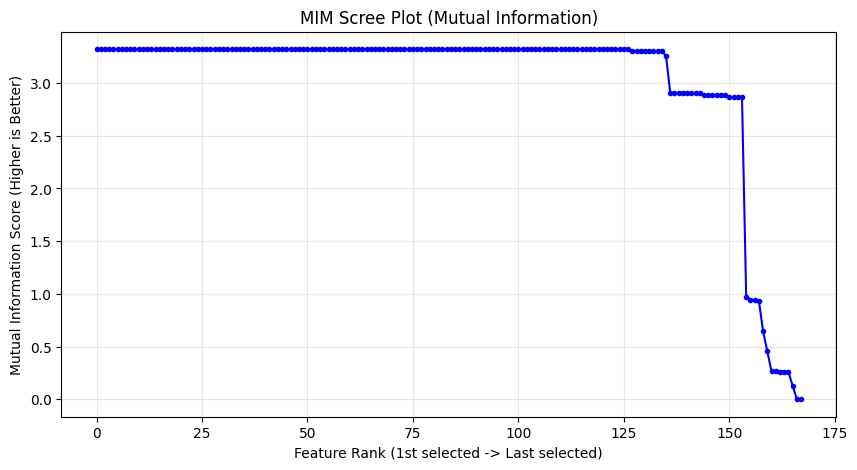

In [21]:
# Plot Sorted Laplacian Scores to select the correct value of k
plt.figure(figsize=(10, 5))
plt.plot(J_mim, 'b-o', markersize=3)
plt.title("MIM Scree Plot (Mutual Information)")
plt.xlabel("Feature Rank (1st selected -> Last selected)")
plt.ylabel("Mutual Information Score (Higher is Better)")
plt.grid(True, alpha=0.3)

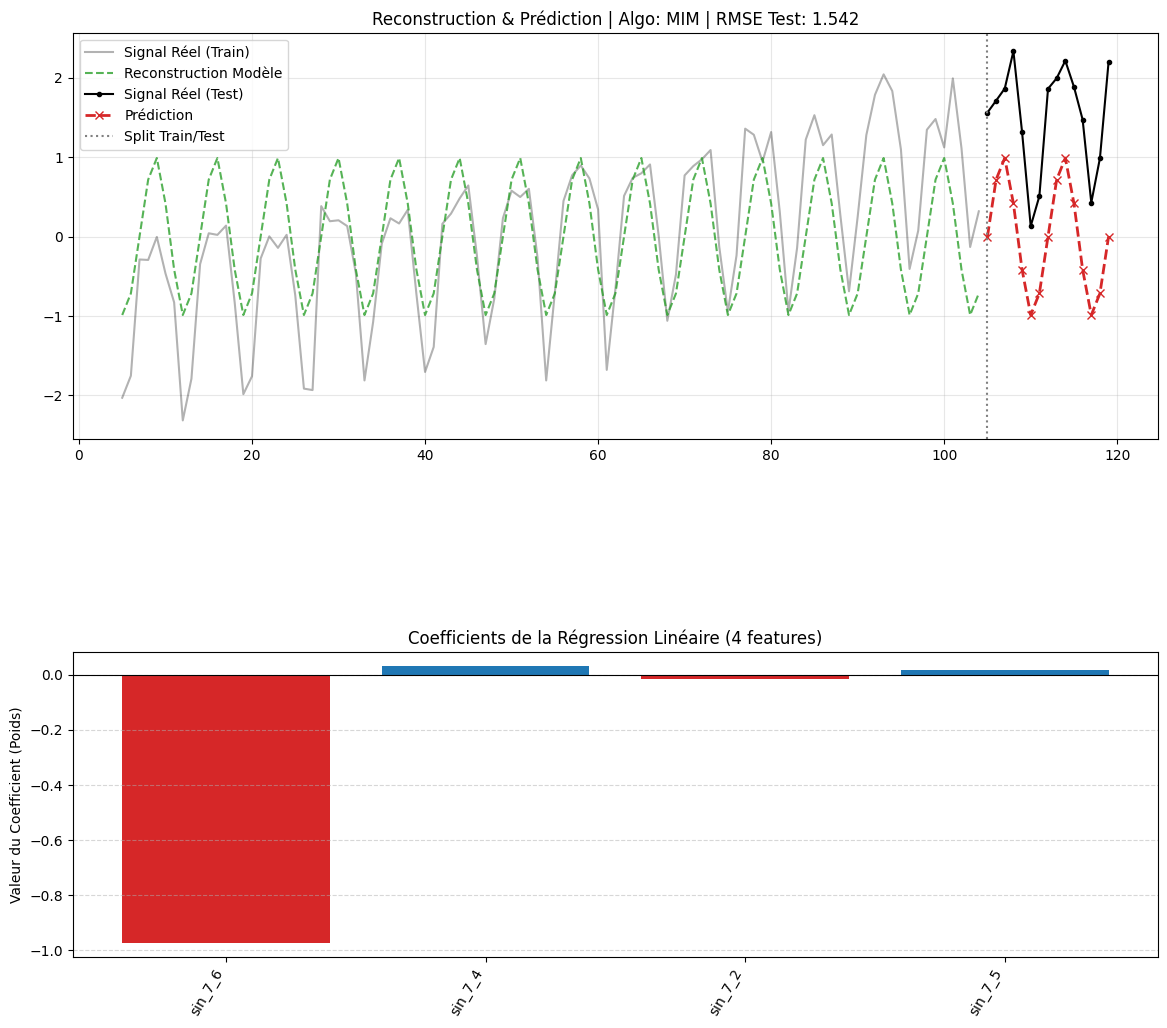

np.float64(1.5415552620270996)

In [22]:
top_k_indices = idx_mim[:k]
X_train_subset = X_train_mega[:, top_k_indices]
X_test_subset  = X_test_mega[:, top_k_indices]

evaluate_and_plot_selection(X_train_full=X_train_mega, 
    y_train=y_train, 
    X_test_full=X_test_mega, 
    y_test=y_test,
    selected_indices=top_k_indices,
    feature_names=X_mega_full.columns,
    algo_name="MIM", 
    time_train=time_array_train, 
    time_test=time_array_pred)

In [23]:
m = evaluate_recovery(
        algo_name='MIM', 
        selected_indices=top_k_indices, 
        true_indices=my_true_indices,       # Vos indices identifiés à l'étape précédente
        true_weights=my_true_weights,       # Vos poids identifiés à l'étape précédente
        feature_names=X_mega_full.columns
    )

--- Évaluation : MIM ---
✅ Trouvés (0) : []
❌ Manqués (4) : ['sin_7_1', 'poly_deg_1', 'poly_deg_2', 'cos_7_2']
⚠️ Intrus  (4) : (Top 3) ['sin_7_5', 'sin_7_2', 'sin_7_6']
🔋 Énergie Retrouvée : 0.0%
------------------------------


#### MRMR

In [24]:
from skfeature.function.information_theoretical_based import MRMR

In [25]:
idx_mrmr, scores_mrmr, _ = MRMR.mrmr(X_train_mega, y_binned, n_selected_features=X_train_mega.shape[1])
print("Top Feature (Info-Theoretic - MRMR):", X_mega_full.columns[idx_mrmr[0]])

Top Feature (Info-Theoretic - MRMR): sin_7_2


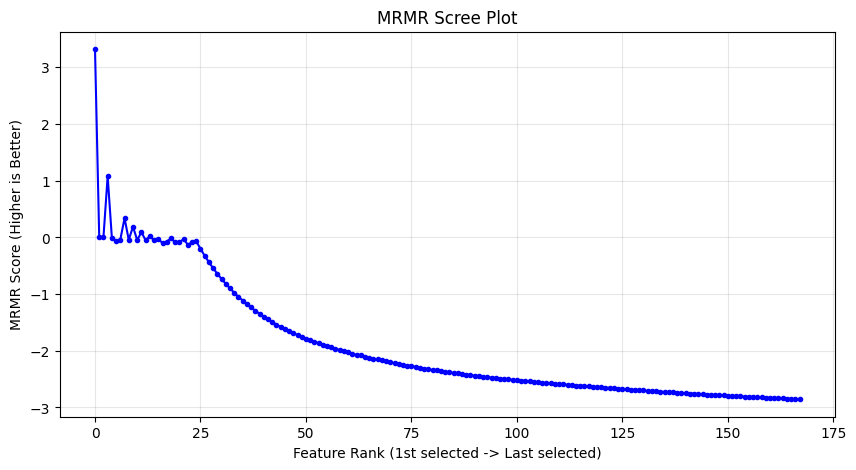

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(scores_mrmr, 'b-o', markersize=3)
plt.title("MRMR Scree Plot")
plt.xlabel("Feature Rank (1st selected -> Last selected)")
plt.ylabel("MRMR Score (Higher is Better)")
plt.grid(True, alpha=0.3)

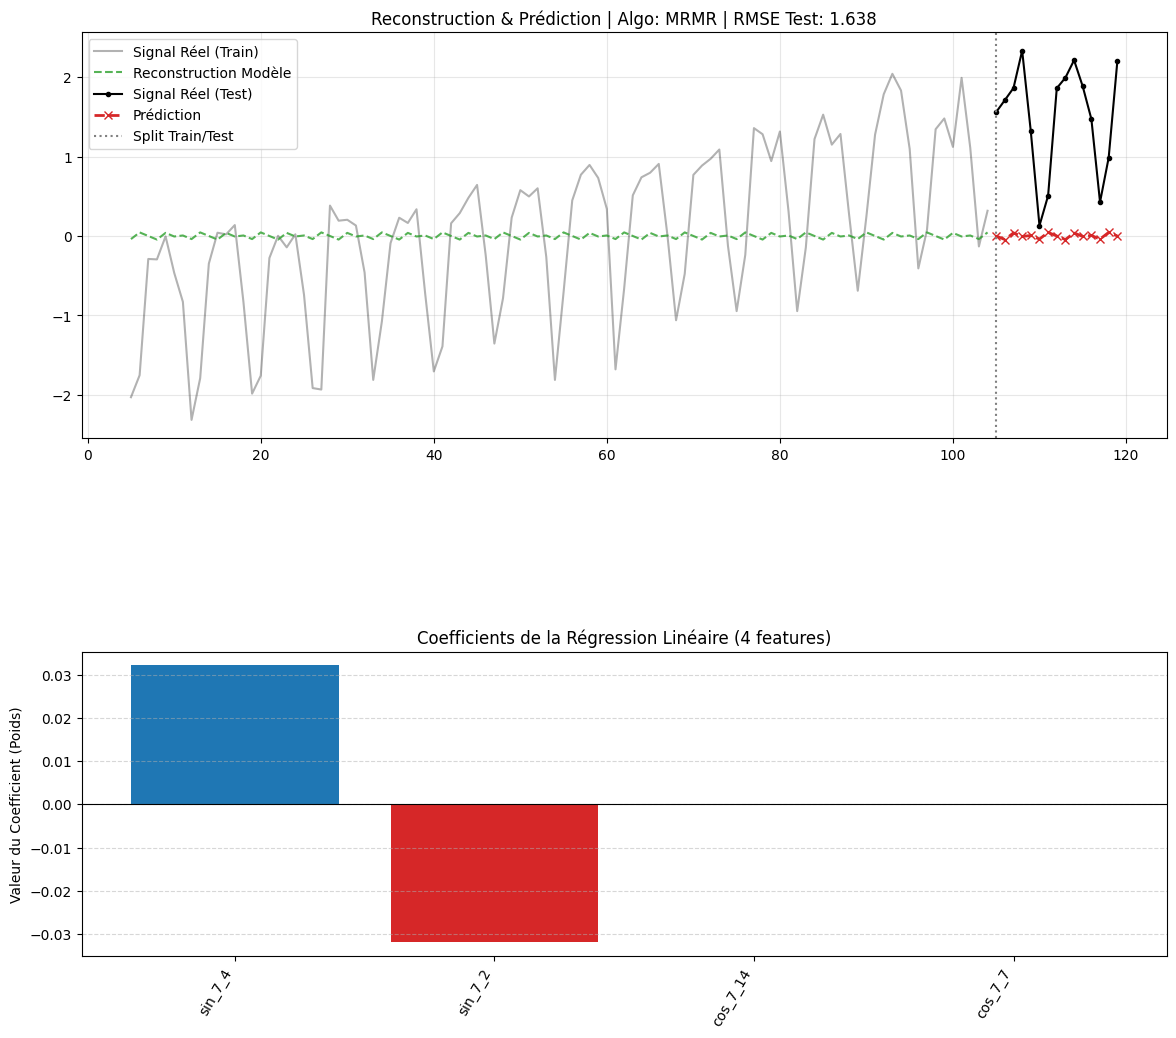

np.float64(1.6382986461128102)

In [27]:
top_k_indices = idx_mrmr[:k]
X_train_subset = X_train_mega[:, top_k_indices]
X_test_subset  = X_test_mega[:, top_k_indices]

evaluate_and_plot_selection(X_train_full=X_train_mega, 
    y_train=y_train, 
    X_test_full=X_test_mega, 
    y_test=y_test,
    selected_indices=top_k_indices,
    feature_names=X_mega_full.columns,
    algo_name="MRMR", 
    time_train=time_array_train, 
    time_test=time_array_pred)

In [28]:
m = evaluate_recovery(
        algo_name='MRMR', 
        selected_indices=top_k_indices, 
        true_indices=my_true_indices,       # Vos indices identifiés à l'étape précédente
        true_weights=my_true_weights,       # Vos poids identifiés à l'étape précédente
        feature_names=X_mega_full.columns
    )

--- Évaluation : MRMR ---
✅ Trouvés (0) : []
❌ Manqués (4) : ['sin_7_1', 'poly_deg_1', 'poly_deg_2', 'cos_7_2']
⚠️ Intrus  (4) : (Top 3) ['sin_7_2', 'cos_7_14', 'cos_7_7']
🔋 Énergie Retrouvée : 0.0%
------------------------------


#### JMI

In [29]:
from skfeature.function.information_theoretical_based import JMI

Top Feature (Info-Theoretic - JMI): sin_7_2


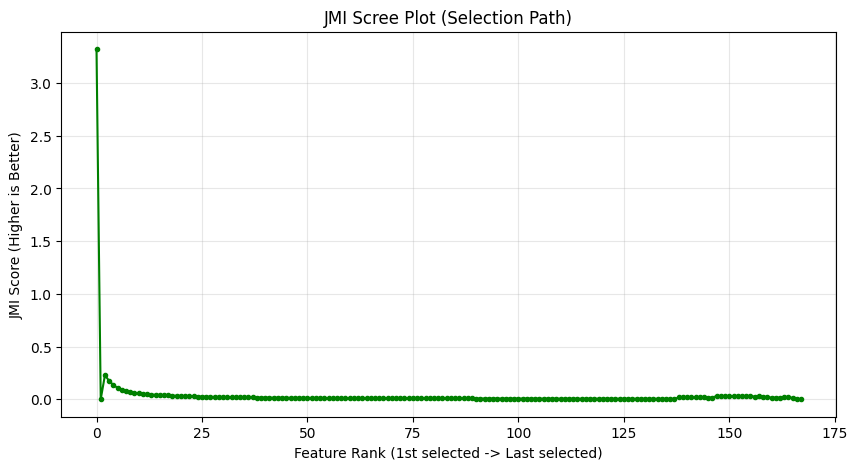

In [30]:
idx_jmi, scores_jmi, _ = JMI.jmi(X_train_mega, y_binned, n_selected_features=X_train_mega.shape[1])
print("Top Feature (Info-Theoretic - JMI):", X_mega_full.columns[idx_jmi[0]])

# 2. Sort scores to visualize the "Scree Plot" correctly
plt.figure(figsize=(10, 5))
plt.plot(scores_jmi, 'g-o', markersize=3)
plt.title("JMI Scree Plot (Selection Path)")
plt.xlabel("Feature Rank (1st selected -> Last selected)")
plt.ylabel("JMI Score (Higher is Better)")
plt.grid(True, alpha=0.3)
plt.show()

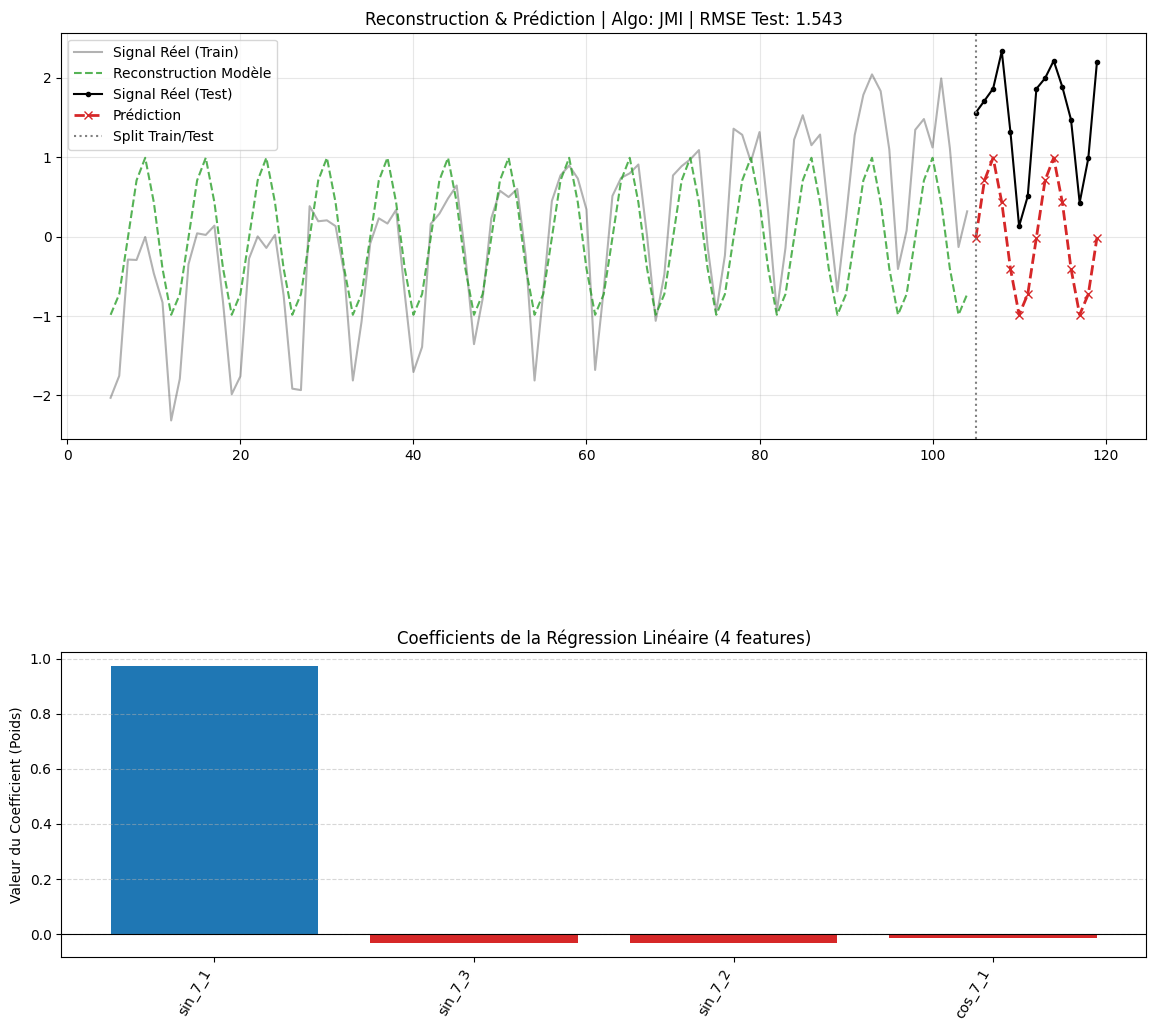

np.float64(1.5425527278694475)

In [31]:
top_k_indices = idx_jmi[:k]
X_train_subset = X_train_mega[:, top_k_indices]
X_test_subset  = X_test_mega[:, top_k_indices]

evaluate_and_plot_selection(X_train_full=X_train_mega, 
    y_train=y_train, 
    X_test_full=X_test_mega, 
    y_test=y_test,
    selected_indices=top_k_indices,
    feature_names=X_mega_full.columns,
    algo_name="JMI", 
    time_train=time_array_train, 
    time_test=time_array_pred)

In [32]:
m = evaluate_recovery(
        algo_name='JMI', 
        selected_indices=top_k_indices, 
        true_indices=my_true_indices,       # Vos indices identifiés à l'étape précédente
        true_weights=my_true_weights,       # Vos poids identifiés à l'étape précédente
        feature_names=X_mega_full.columns
    )

--- Évaluation : JMI ---
✅ Trouvés (1) : ['sin_7_1']
❌ Manqués (3) : ['poly_deg_1', 'poly_deg_2', 'cos_7_2']
⚠️ Intrus  (3) : (Top 3) ['cos_7_1', 'sin_7_2', 'sin_7_3']
🔋 Énergie Retrouvée : 70.9%
------------------------------


#### CMIM

In [33]:
from skfeature.function.information_theoretical_based import CMIM

Top Feature (Info-Theoretic - CMIM): sin_7_2


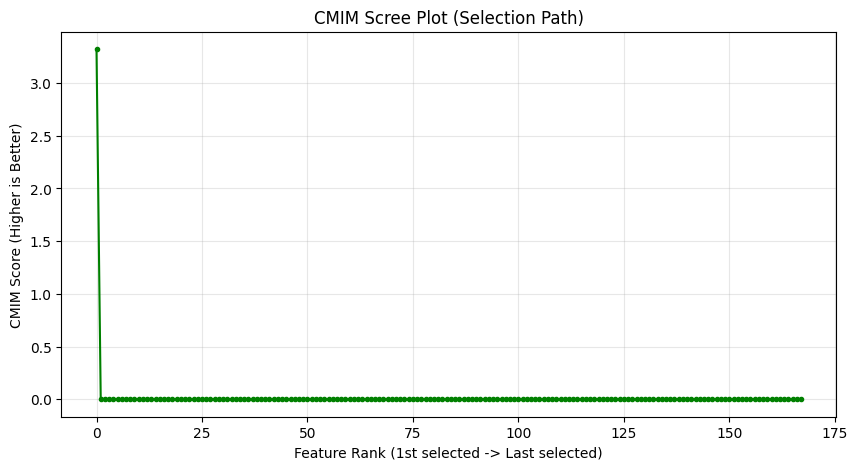

In [34]:
idx_cmim, scores_cmim, _ = CMIM.cmim(X_train_mega, y_binned, n_selected_features=X_train_mega.shape[1])
print("Top Feature (Info-Theoretic - CMIM):", X_mega_full.columns[idx_cmim[0]])

# 2. Sort scores to visualize the "Scree Plot" correctly
plt.figure(figsize=(10, 5))
plt.plot(scores_cmim, 'g-o', markersize=3)
plt.title("CMIM Scree Plot (Selection Path)")
plt.xlabel("Feature Rank (1st selected -> Last selected)")
plt.ylabel("CMIM Score (Higher is Better)")
plt.grid(True, alpha=0.3)
plt.show()

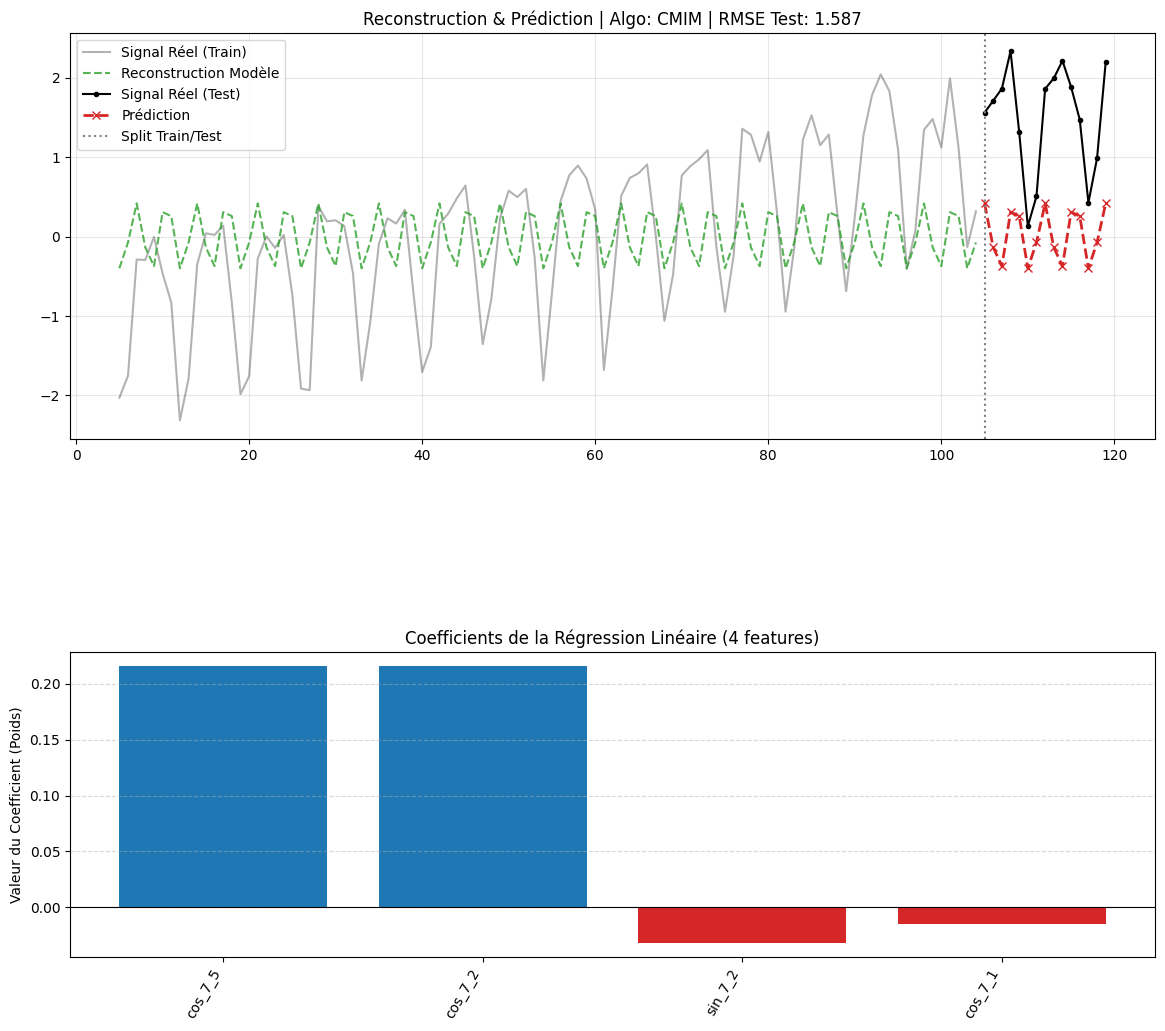

np.float64(1.5871063879398726)

In [35]:
top_k_indices = idx_cmim[:k]
X_train_subset = X_train_mega[:, top_k_indices]
X_test_subset  = X_test_mega[:, top_k_indices]

evaluate_and_plot_selection(X_train_full=X_train_mega, 
    y_train=y_train, 
    X_test_full=X_test_mega, 
    y_test=y_test,
    selected_indices=top_k_indices,
    feature_names=X_mega_full.columns,
    algo_name="CMIM", 
    time_train=time_array_train, 
    time_test=time_array_pred)

In [36]:
m = evaluate_recovery(
        algo_name='CMIM', 
        selected_indices=top_k_indices, 
        true_indices=my_true_indices,       # Vos indices identifiés à l'étape précédente
        true_weights=my_true_weights,       # Vos poids identifiés à l'étape précédente
        feature_names=X_mega_full.columns
    )

--- Évaluation : CMIM ---
✅ Trouvés (1) : ['cos_7_2']
❌ Manqués (3) : ['sin_7_1', 'poly_deg_1', 'poly_deg_2']
⚠️ Intrus  (3) : (Top 3) ['cos_7_1', 'sin_7_2', 'cos_7_5']
🔋 Énergie Retrouvée : 28.4%
------------------------------


#### LASSO